In [4]:
library(gam)
library(mvgam)           # Fit, interrogate and forecast DGAMs
library(dplyr)           # Tidy and flexible data manipulation
library(marginaleffects) # Compute conditional and marginal effects
library(ggplot2)         # Flexible plotting
library(patchwork)       # Combining ggplot objects


Loading required package: splines

Loading required package: foreach

Loaded gam 1.22-5


Welcome to mvgam. Please cite as: Clark, NJ, and Wells, K. 2022. Dynamic Generalized Additive Models (DGAMs) for forecasting discrete ecological time series. Methods in Ecology and Evolution, 2022, https://doi.org/10.1111/2041-210X.13974


Attaching package: ‘mvgam’


The following object is masked from ‘package:gam’:

    s



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
theme_set(theme_classic(base_size = 25, base_family = 'serif') +
            theme(axis.line.x.bottom = element_line(colour = "black",
                                                    size = 1),
                  axis.line.y.left = element_line(colour = "black",
                                                  size = 1)))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


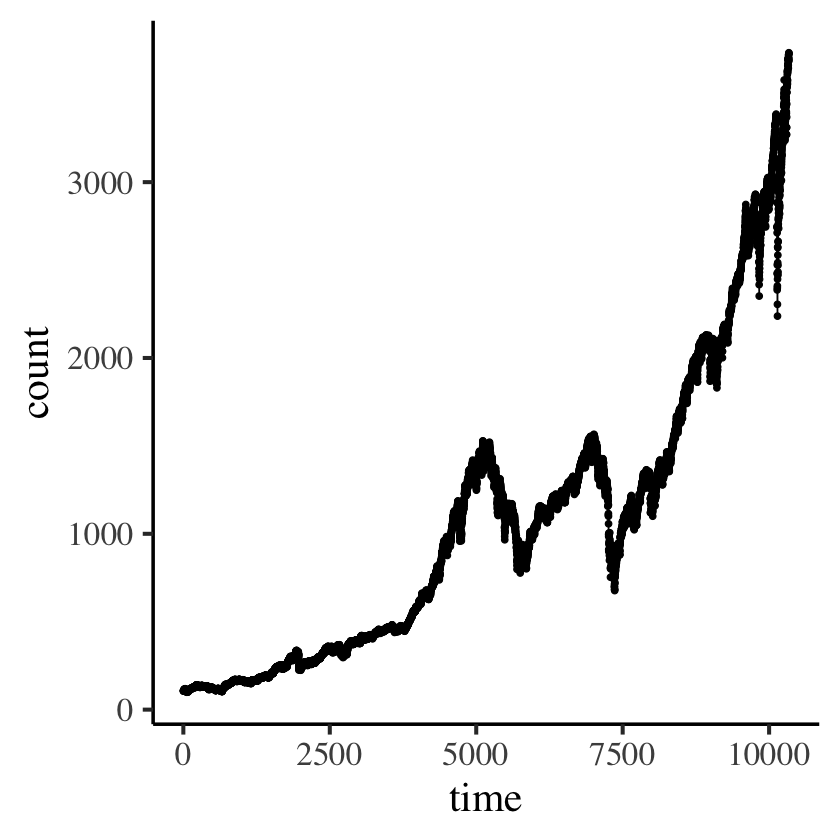

In [7]:
dat <- read.csv("sp500_train.csv")
ggplot(dat, aes(time, count)) + 
  geom_point() +
  geom_line()

In [59]:
# Replicating mgcv::gam.check() but without the plots
small_check = function(model){
  cat("Basis dimension (k) checking results. Low p-value (k-index < 1) may\n") 
  cat("indicate that k is too low, especially if edf is close to k\'.\n\n")
  printCoefmat(mgcv::k.check(model), digits = 3)
}

# Call marginaleffects::plot_predictions to inspect model fits
plot_fcs = function(model, n_ahead = 0){
  p <- plot_predictions(model, 
                   condition = list(time = 1:(max(dat$time) + n_ahead)),
                   type = 'response',
                   points = 0.5)
  
  if(n_ahead > 0){
    p <- p + 
      geom_vline(xintercept = max(dat$time), 
                 linetype = 'dashed')
  }
  p
}

plot_links = function(model, n_ahead = 0){
  p <- plot_predictions(model, 
                   condition = list(time = 1:(max(dat$time) + n_ahead)),
                   type = 'link') +
    ylab('linear predictor')
  
    if(n_ahead > 0){
    p <- p + 
      geom_vline(xintercept = max(dat$time), 
                 linetype = 'dashed')
  }
  p
}

In [15]:
mod5 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 23,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = dat,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Compiling Stan program using cmdstanr



Start sampling



Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling)

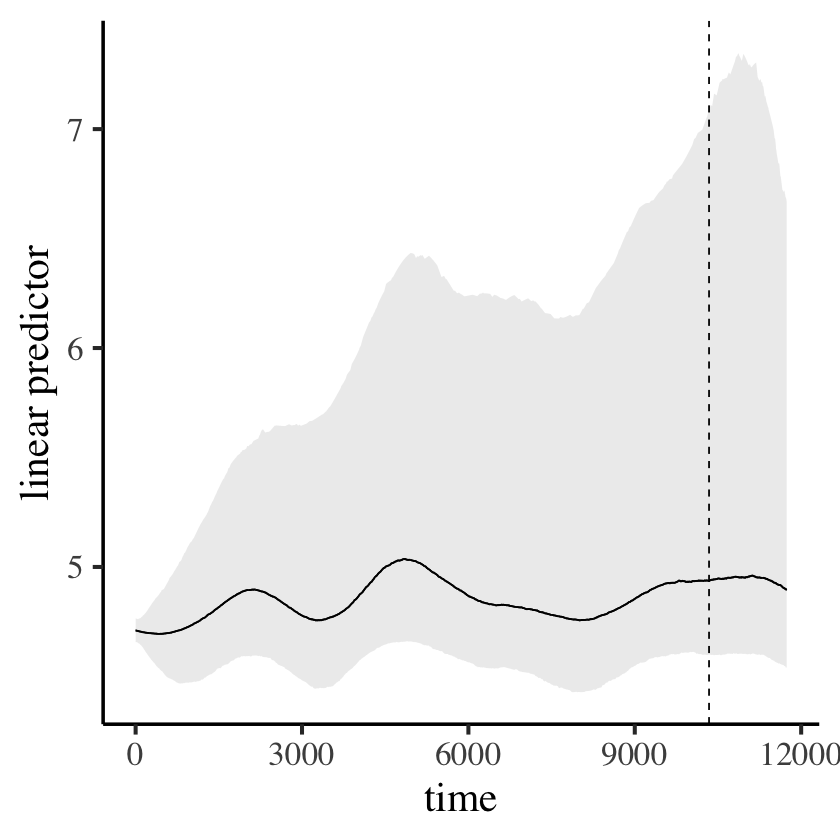

In [23]:
## predict all the way into 2024 Nov
plot_links(mod5, n_ahead = 1400)

## Things I know so far..
#### 1. This model fit the data, but it took 2619.6 seconds... (43.6 minutes..)
#### 2. The y-values (stock price) is normalized, but it is clear how the predictions are behaving.
#### 3. The gray area is the +- standard deviation. The learned curve could've been fitted to any of the range in gray.
#### 4. The data that was learned seems to greatly underfit the data. I will have to adjust the number of splines 'k'.
#### 5. beyond the dotted line on the y axis is the 1400 days into the future and the uncertainty (deviation) becomes exponentially larger.

## Next Steps: 
#### • The data that was learned seems to greatly underfit the data. I will have to adjust the number of splines 'k'.
#### • But first, I need to import a much smaller test data.
#### • Let's try the last 5 years of train data..

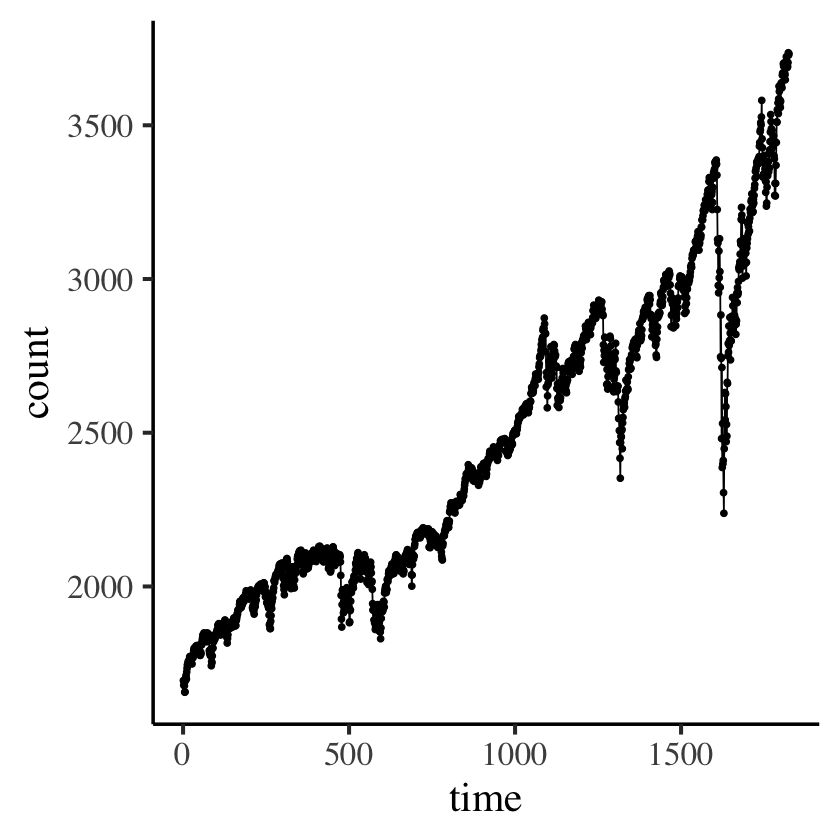

In [31]:
smaller_data <- read.csv("sp500_train_s.csv")
ggplot(smaller_data, aes(time, count)) + 
  geom_point() +
  geom_line()

### • This time instead of using the plot function, used by the author of MVGAM, which normalizes the y-axis, let's show the true y-value by making a new plot function.

In [84]:
plot_x_y = function(model, n_ahead=0){
    pp <- plot_predictions(model, 
                      condition = list(time = 1:(max(smaller_data$time) + n_ahead)),
                      type = 'response') +
    ylab('Expected counts')
    if(n_ahead > 0){
    pp <- pp + 
      geom_vline(xintercept = max(smaller_data$time), 
                 linetype = 'dashed')
  }
  pp
}

## • Training 3 different models with different k values

In [36]:
mod_k5 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 5,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = smaller_data,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Compiling Stan program using cmdstanr



Start sampling



Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling)

In [74]:
mod_k10 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 10,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = smaller_data,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Compiling Stan program using cmdstanr



Start sampling



Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 


In [75]:
mod_k30 <- mvgam(count ~ 1,
              trend_formula = ~ gp(time, c = 5/4, k = 30,
                                   scale = FALSE),
              trend_model = AR(),
              priors = prior_string(prior ='normal(16, 4)', 
                                    class = 'rho_gp_trend(time)'),
            data = smaller_data,
            family = poisson())

Your model may benefit from using "noncentred = TRUE"

Compiling Stan program using cmdstanr



Start sampling



Running MCMC with 4 parallel chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 1000 / 1000 [100%] 

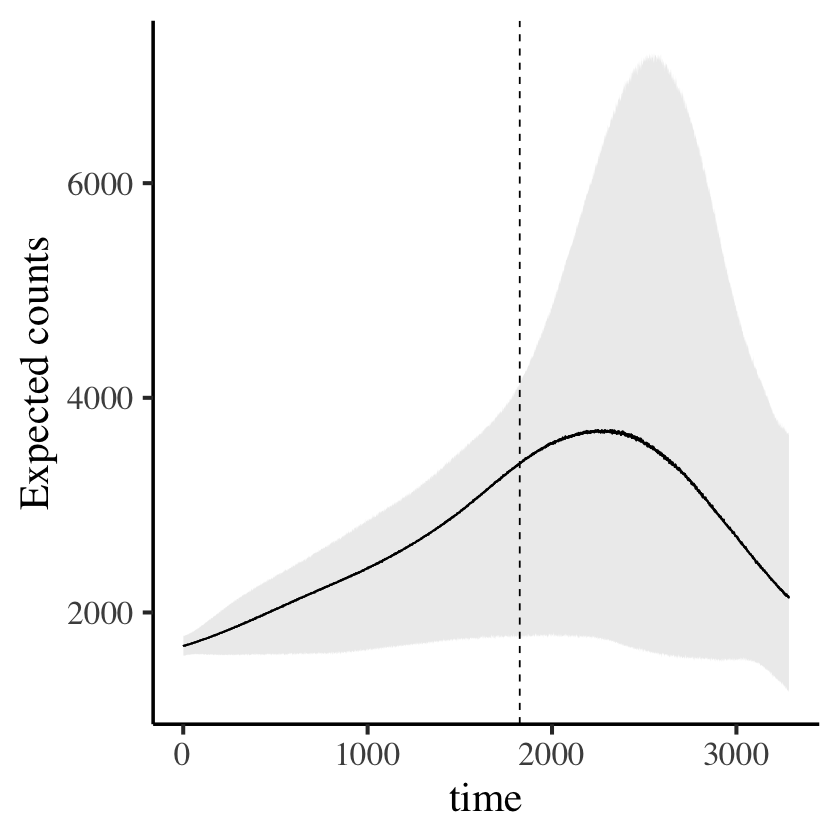

In [89]:
plot_x_y(mod_k5, n_ahead = (1460))

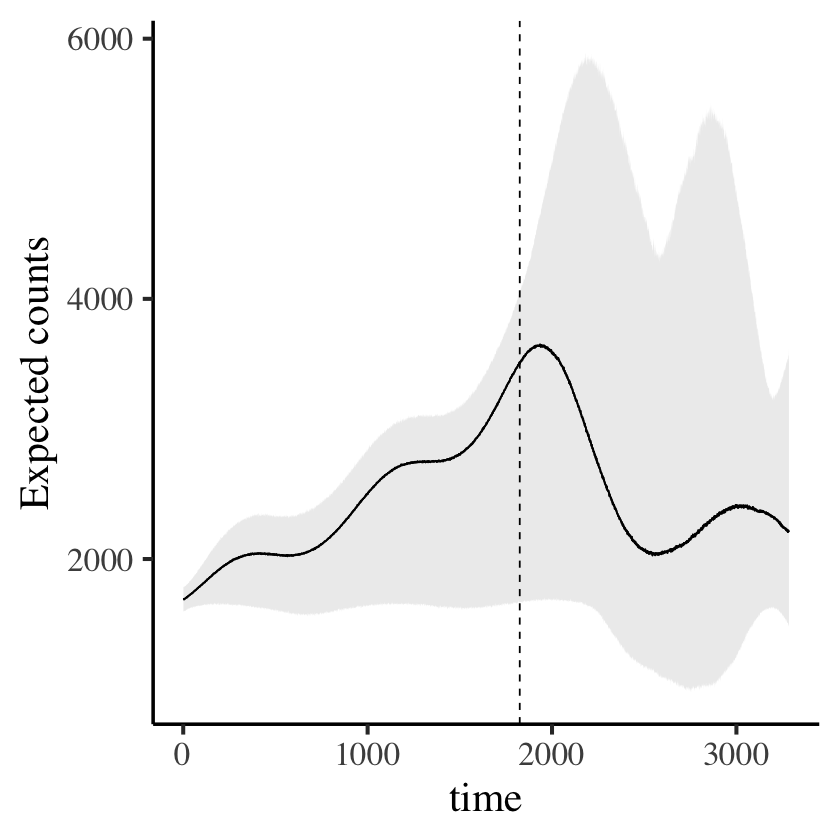

In [91]:
plot_x_y(mod_k10, 1460)

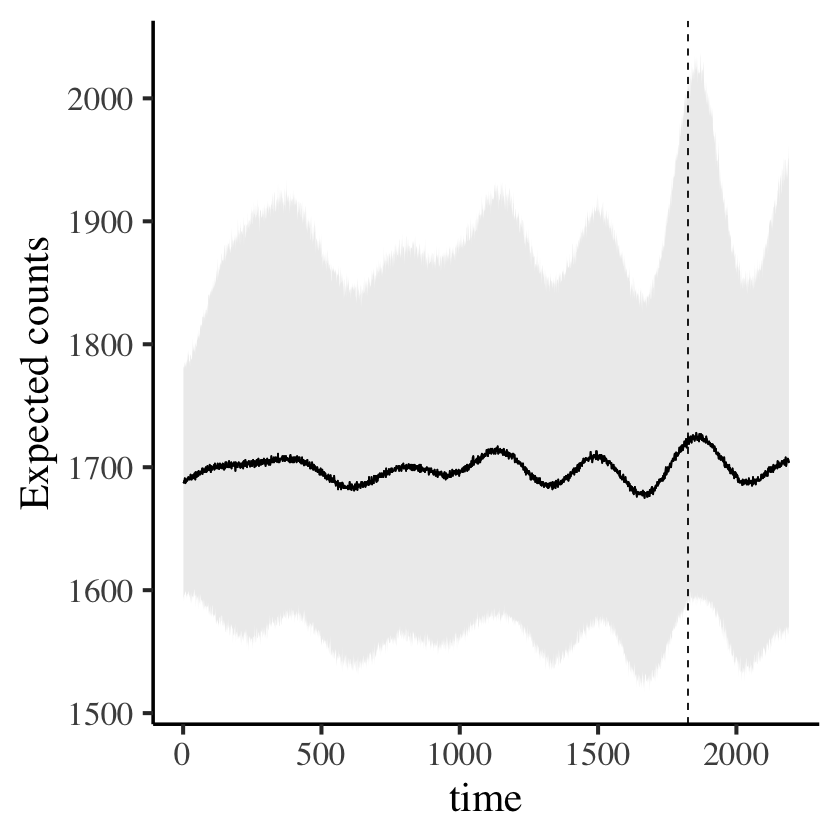

In [93]:
plot_x_y(mod_k30, 365)

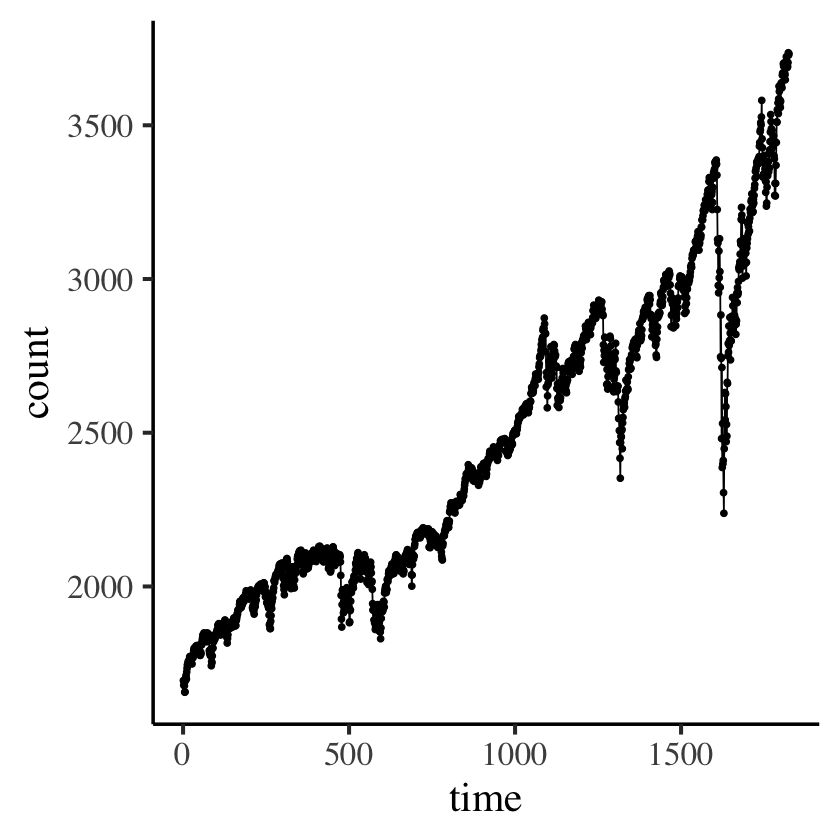

In [100]:
#Actual data before the dotted line:
smaller_data <- read.csv("sp500_train_s.csv")
ggplot(smaller_data, aes(time, count)) + 
  geom_point() +
  geom_line()

## • Analysis
#### • By visual investigation k fits the actual stock test data the best 
#### • The larger k=30 seems to somehow both overfit and underfit the data. It attempts to overfit, but the line is too flat that it's actually underfitting. 
#### • None of the models were even close at predicting 2021-2024 actual prices correctly.
#### • model 'mod_k10's predictions will be sent back to the main project "predictor_project.ipynb" 

In [105]:
plot_x_y_p = function(model, n_ahead=0){
    pp <- plot_predictions(model, 
                      condition = list(time = 1:(max(smaller_data$time) + n_ahead)),
                      type = 'response') +
    ylab('Expected counts')
    if(n_ahead > 0){
    pp <- pp + 
      geom_vline(xintercept = max(smaller_data$time), 
                 linetype = 'dashed')
  }
  print(max(smaller_data$time))
  pp
}

[1] 1825


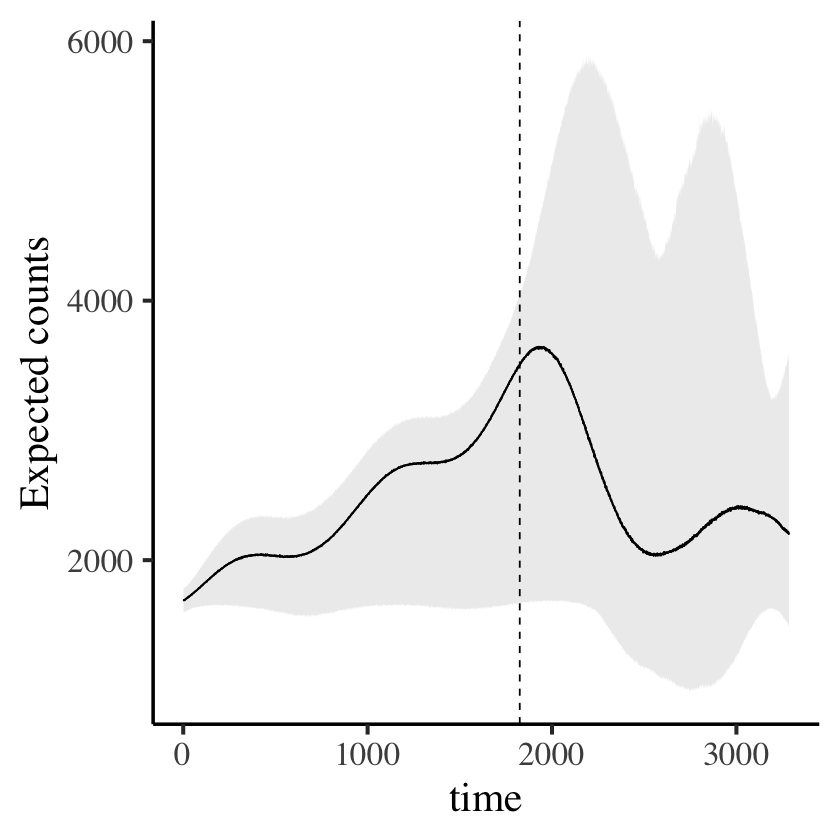

In [107]:
plot_x_y_p(mod_k10, 1460)

## • Let's attempt to export the prediction values to get the RMSE
## • Spoiler: it doesn't go well as there is no explicit support for printing out predicictions nor RMSE score in the official pdf: https://nicholasjclark.github.io/mvgam/index.html

In [113]:
# Generate a data frame with future time points
future_data <- data.frame(
  time = (max(smaller_data$time) + 1):(max(smaller_data$time) + 365)
  # Add other covariates required by your model, with appropriate values
)

# Forecast using the mvgam model
future_forecast <- forecast(model = mod_k10, newdata = future_data, type = 'response')


ERROR: Error in forecast(model = mod_k10, newdata = future_data, type = "response"): argument "object" is missing, with no default


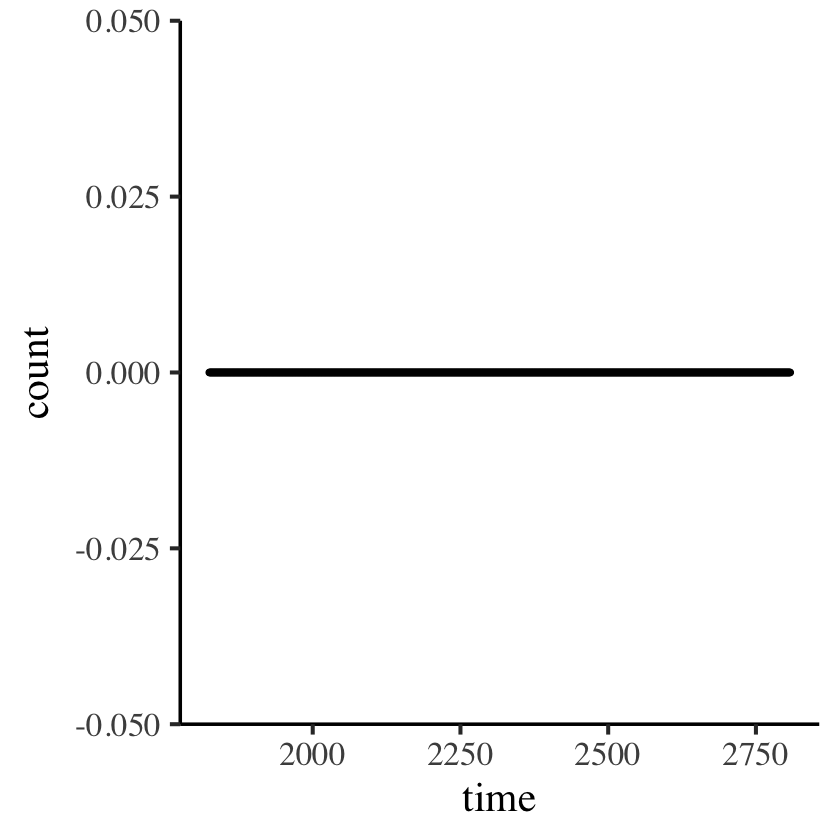

In [120]:
smaller_test_data <- read.csv("sp500_test_s.csv")
ggplot(smaller_test_data, aes(time, count)) + 
  geom_point() +
  geom_line()

In [124]:
future_forecast <- forecast(mod_k10, newdata = smaller_test_data, type = 'response')

In [128]:
write.csv(future_forecast, file = "mvgam_predictions.csv", row.names = FALSE)

ERROR: Error in as.data.frame.default(x[[i]], optional = TRUE, stringsAsFactors = stringsAsFactors): cannot coerce class ‘"mvgam_forecast"’ to a data.frame


In [130]:
str(future_forecast)

List of 16
 $ call              :Class 'formula'  language count ~ 1
  .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
 $ trend_call        :Class 'formula'  language ~gp(time, c = 5/4, k = 10, scale = FALSE)
  .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
 $ family            : chr "poisson"
 $ family_pars       : NULL
 $ trend_model       :List of 4
  ..$ trend_model: chr "AR1"
  ..$ ma         : logi FALSE
  ..$ cor        : logi FALSE
  ..$ label      : language AR()
  ..- attr(*, "class")= chr "mvgam_trend"
 $ drift             : logi FALSE
 $ use_lv            : logi TRUE
 $ fit_engine        : chr "stan"
 $ type              : chr "response"
 $ series_names      : Factor w/ 1 level "series1": 1
 $ train_observations:List of 1
  ..$ series1: int [1:1825] 1694 1679 1691 1677 1656 1657 1693 1704 1711 1699 ...
 $ train_times       : int [1:1825] 1 2 3 4 5 6 7 8 9 10 ...
 $ test_observations :List of 1
  ..$ series1: int [1:983] 0 0 0 0 0 0 0 0 0 0 ...
 $ test

In [139]:
write.csv(future_forecast$forecasts, file = "mvgam_predictions.csv", row.names = FALSE)
